In [3]:
# Cell 1: Setup and Imports
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme()  # This sets the seaborn style
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Setup paths
notebook_dir = Path(os.getcwd())
project_root = notebook_dir.parent
sys.path.append(str(project_root))

# Import our fetcher
from scripts.data_fetcher import DarkPoolDataFetcher

# Configure matplotlib
# plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# Set timezone to CET (Central European Time)
cet = pytz.timezone('CET')

# For reference, also set US/Eastern for market hours
eastern = pytz.timezone('US/Eastern')

# Define market hours in CET
MARKET_OPEN_CET = datetime.now(cet).replace(hour=15, minute=30, second=0, microsecond=0)
MARKET_CLOSE_CET = datetime.now(cet).replace(hour=22, minute=0, second=0, microsecond=0)

In [81]:
# Cell 2: Helper Functions
def get_target_date(use_today: bool = False) -> datetime:
    """
    Get target date for data fetching
    If the date falls on a weekend, returns the last trading day (Friday)
    """
    now = datetime.now()
    if use_today:
        target_date = now
    else:
        target_date = now - timedelta(days=1)
    
    # If the target date is a weekend, get the last Friday
    if target_date.weekday() >= 5:  # 5 is Saturday, 6 is Sunday
        days_to_subtract = target_date.weekday() - 4  # 4 is Friday
        target_date = target_date - timedelta(days=days_to_subtract)
        print(f"Adjusted date from weekend to last trading day: {target_date.strftime('%Y-%m-%d')}")
    
    return target_date

def get_csv_path(date: datetime, symbol: str) -> Path:
    """Get path for cached CSV file"""
    date_str = date.strftime("%Y-%m-%d")
    return RAW_DATA_DIR / "darkpool" / date_str / f"{symbol}_trades.csv"

In [94]:
def fetch_all_trades(symbols=['SPY', 'QQQ'], use_today=False, force_refresh=False):
    """
    Fetch ALL trades for given symbols with data caching
    
    Parameters:
    - symbols: list of symbols to fetch
    - use_today: if True, fetch today's data instead of yesterday's
    - force_refresh: if True, fetch new data even if cache exists
    
    Returns:
    - DataFrame with all trades
    """
    target_date = get_target_date(use_today)
    print(f"Fetching trades for date: {target_date.strftime('%Y-%m-%d')}")
    all_trades = []
    
    for symbol in symbols:
        csv_path = get_csv_path(target_date, symbol)
        csv_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Check if we have cached data
        if not force_refresh and csv_path.exists():
            print(f"Loading cached data for {symbol} from {csv_path}")
            symbol_trades = pd.read_csv(csv_path)
            all_trades.append(symbol_trades)
            continue
            
        print(f"Fetching trades for {symbol}...")
        symbol_trades = []
        offset = 0
        total_trades = 0
        seen_tracking_ids = set()  # Track unique trades
        
        # Use the recent endpoint
        endpoint = f"{DARKPOOL_ENDPOINT}/recent"
        params = {
            "symbol": symbol,
            "offset": offset,
            "limit": 200  # API limit is 200
        }
        
        while True:
            try:
                print(f"Requesting trades with params: {params}")
                response = requests.get(
                    endpoint,
                    headers=DEFAULT_HEADERS,
                    params=params,
                    timeout=REQUEST_TIMEOUT
                )
                response.raise_for_status()
                data = response.json()
                
                if not data or "data" not in data or not data["data"]:
                    print(f"No more trades found for {symbol} after offset {offset}")
                    break
                
                trades = pd.DataFrame(data["data"])
                trades_count = len(trades)
                
                if trades_count == 0:
                    print(f"No trades returned for offset {offset}")
                    break
                
                # Convert executed_at to datetime
                trades['executed_at'] = pd.to_datetime(trades['executed_at'])
                
                # Filter trades for the target date
                trades = trades[trades['executed_at'].dt.date == target_date.date()]
                
                if len(trades) == 0:
                    print(f"No trades found for {symbol} on {target_date.strftime('%Y-%m-%d')} at offset {offset}")
                    break
                
                # Clean numeric columns
                numeric_columns = ['price', 'size', 'premium', 'price_impact']
                for col in numeric_columns:
                    if col in trades.columns:
                        trades[col] = pd.to_numeric(trades[col], errors='coerce')
                
                # Check for duplicates
                if 'tracking_id' in trades.columns:
                    new_trades = trades[~trades['tracking_id'].isin(seen_tracking_ids)]
                    duplicates = len(trades) - len(new_trades)
                    if duplicates > 0:
                        print(f"Found {duplicates} duplicate trades in this batch")
                    trades = new_trades
                    seen_tracking_ids.update(trades['tracking_id'])
                
                # If we got no new trades, we've reached the end
                if len(trades) == 0:
                    print(f"No new trades found at offset {offset}, ending pagination")
                    break
                
                symbol_trades.append(trades)
                total_trades += len(trades)
                print(f"Fetched {len(trades)} trades for {symbol} (Offset: {offset}, Total: {total_trades})")
                
                # Rate limiting
                time.sleep(1.0 / REQUEST_RATE_LIMIT)
                
                # Increment offset for next batch
                offset += 200  # Match the limit
                params['offset'] = offset
                
            except requests.exceptions.HTTPError as e:
                print(f"Error fetching trades at offset {offset} for {symbol}: {str(e)}")
                print(f"Response content: {e.response.content if hasattr(e, 'response') else 'No response'}")
                break
            except Exception as e:
                print(f"Error fetching trades at offset {offset} for {symbol}: {str(e)}")
                if isinstance(e, requests.exceptions.RequestException):
                    print(f"Response content: {e.response.content if hasattr(e, 'response') else 'No response'}")
                break
        
        if symbol_trades:
            # Combine all pages for this symbol
            symbol_df = pd.concat(symbol_trades, ignore_index=True)
            
            # Remove duplicates if any
            symbol_df = symbol_df.drop_duplicates(subset=['tracking_id']) if 'tracking_id' in symbol_df.columns else symbol_df
            
            # Save to CSV
            symbol_df.to_csv(csv_path, index=False)
            print(f"Saved {len(symbol_df)} unique trades to {csv_path}")
            
            all_trades.append(symbol_df)
    
    if all_trades:
        combined_df = pd.concat(all_trades, ignore_index=True)
        print(f"\nTotal trades fetched across all symbols: {len(combined_df)}")
        return combined_df
    
    return pd.DataFrame()

In [59]:
# Cell 3: Analysis Functions
def analyze_sentiment(trades_df):
    """
    Analyze overall sentiment based on trade characteristics
    
    Parameters:
    - trades_df: DataFrame containing trades
    
    Returns:
    - Dictionary containing sentiment metrics
    """
    if trades_df.empty:
        return {
            'vwap_premium': 0,
            'sentiment_score': 0,
            'bullish_volume': 0,
            'bearish_volume': 0
        }
    
    # Calculate volume-weighted average premium
    vwap_premium = np.average(trades_df['premium'], weights=trades_df['size'])
    
    # Calculate percentage of trades above vs below price
    trades_df['trade_direction'] = trades_df['premium'].apply(lambda x: 'bullish' if x > 0 else 'bearish')
    direction_volume = trades_df.groupby('trade_direction')['size'].sum()
    
    # Calculate sentiment score (-1 to 1)
    total_volume = direction_volume.sum()
    if 'bullish' in direction_volume and 'bearish' in direction_volume:
        sentiment_score = (direction_volume['bullish'] - direction_volume['bearish']) / total_volume
    else:
        sentiment_score = 0
        
    return {
        'vwap_premium': vwap_premium,
        'sentiment_score': sentiment_score,
        'bullish_volume': direction_volume.get('bullish', 0),
        'bearish_volume': direction_volume.get('bearish', 0)
    }

In [60]:
# Cell 3: Analysis Functions
def analyze_sentiment(trades_df):
    """
    Analyze overall sentiment based on trade characteristics
    
    Parameters:
    - trades_df: DataFrame containing trades
    
    Returns:
    - Dictionary containing sentiment metrics
    """
    if trades_df.empty:
        return {
            'vwap_premium': 0,
            'sentiment_score': 0,
            'bullish_volume': 0,
            'bearish_volume': 0
        }
    
    # Calculate volume-weighted average premium
    vwap_premium = np.average(trades_df['premium'], weights=trades_df['size'])
    
    # Calculate percentage of trades above vs below price
    trades_df['trade_direction'] = trades_df['premium'].apply(lambda x: 'bullish' if x > 0 else 'bearish')
    direction_volume = trades_df.groupby('trade_direction')['size'].sum()
    
    # Calculate sentiment score (-1 to 1)
    total_volume = direction_volume.sum()
    if 'bullish' in direction_volume and 'bearish' in direction_volume:
        sentiment_score = (direction_volume['bullish'] - direction_volume['bearish']) / total_volume
    else:
        sentiment_score = 0
        
    return {
        'vwap_premium': vwap_premium,
        'sentiment_score': sentiment_score,
        'bullish_volume': direction_volume.get('bullish', 0),
        'bearish_volume': direction_volume.get('bearish', 0)
    }

In [61]:
# Cell 4: Visualization Functions
def plot_dark_pool_analysis(trades_df, symbol, target_price=None):
    """
    Create comprehensive visualization of dark pool data
    
    Parameters:
    - trades_df: DataFrame containing trades
    - symbol: Symbol to analyze
    - target_price: Optional price level to highlight
    """
    # Create a copy of the filtered data to avoid warnings
    symbol_trades = trades_df[trades_df['ticker'] == symbol].copy()
    
    if symbol_trades.empty:
        print(f"No trades found for {symbol}")
        return
    
    plt.figure(figsize=(20, 15))
    
    # 1. Price Distribution with Volume
    plt.subplot(3, 2, 1)
    sns.histplot(data=symbol_trades, x='price', weights='size', bins=50)
    if target_price:
        plt.axvline(x=target_price, color='r', linestyle='--', label=f'${target_price} Target')
    plt.title(f'{symbol} Price Distribution (Volume Weighted)')
    plt.xlabel('Price')
    plt.ylabel('Volume')
    plt.legend()
    
    # 2. Premium vs Price Impact
    plt.subplot(3, 2, 2)
    plt.scatter(symbol_trades['premium'], symbol_trades['price_impact'], 
               alpha=0.5, s=symbol_trades['size']/symbol_trades['size'].mean()*100)
    plt.title(f'{symbol} Premium vs Price Impact')
    plt.xlabel('Premium')
    plt.ylabel('Price Impact')
    
    # 3. Volume by Price Range
    plt.subplot(3, 2, 3)
    try:
        # Get unique prices and their volumes
        price_volume = symbol_trades.groupby('price')['size'].sum().reset_index()
        # Create bins based on percentiles to avoid duplicates
        n_bins = 10
        price_volume['bin'] = pd.qcut(price_volume['price'], q=n_bins, duplicates='drop')
        volume_by_range = price_volume.groupby('bin')['size'].sum()
        
        # Plot with readable labels
        ax = volume_by_range.plot(kind='bar')
        plt.title(f'{symbol} Volume by Price Range')
        # Format x-axis labels to show price ranges
        labels = [f"${interval.left:.2f}-${interval.right:.2f}" 
                 for interval in volume_by_range.index]
        ax.set_xticklabels(labels, rotation=45, ha='right')
        plt.xlabel('Price Range')
        plt.ylabel('Volume')
    except Exception as e:
        print(f"Error in price range plot: {e}")
        # Fallback to simple price distribution
        sns.histplot(data=symbol_trades, x='price', weights='size', bins=20)
        plt.title(f'{symbol} Volume Distribution by Price')
        plt.xlabel('Price')
        plt.ylabel('Volume')
    
    # 4. Time Series of Trades
    plt.subplot(3, 2, 4)
    symbol_trades['hour'] = pd.to_datetime(symbol_trades['timestamp']).dt.hour
    hourly_volume = symbol_trades.groupby('hour')['size'].sum()
    hourly_volume.plot(kind='bar')
    plt.title(f'{symbol} Volume by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Volume')
    
    # 5. Premium Distribution
    plt.subplot(3, 2, 5)
    sns.histplot(data=symbol_trades, x='premium', weights='size', bins=50)
    plt.title(f'{symbol} Premium Distribution (Volume Weighted)')
    plt.xlabel('Premium')
    plt.ylabel('Volume')
    
    # 6. Cumulative Volume Profile
    plt.subplot(3, 2, 6)
    sorted_prices = symbol_trades.sort_values('price')
    sorted_prices['cumulative_volume'] = sorted_prices['size'].cumsum()
    sorted_prices['volume_percentage'] = sorted_prices['cumulative_volume'] / sorted_prices['size'].sum() * 100
    plt.plot(sorted_prices['price'], sorted_prices['volume_percentage'])
    if target_price:
        plt.axvline(x=target_price, color='r', linestyle='--', label=f'${target_price} Target')
    plt.title(f'{symbol} Cumulative Volume Profile')
    plt.xlabel('Price')
    plt.ylabel('Cumulative Volume %')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Adjusted date from weekend to last trading day: 2025-04-11
Fetching trades for date: 2025-04-11
Fetching trades for SPY...
Requesting trades with params: {'symbol': 'SPY', 'offset': 0, 'limit': 200}
Fetched 200 trades for SPY (Offset: 0, Total: 200)
Requesting trades with params: {'symbol': 'SPY', 'offset': 200, 'limit': 200}
Found 200 duplicate trades in this batch
No new trades found at offset 200, ending pagination
Saved 200 unique trades to /Users/iversen/Work/veveve/vvv-invest/flow_analysis/data/raw/darkpool/2025-04-11/SPY_trades.csv
Fetching trades for QQQ...
Requesting trades with params: {'symbol': 'QQQ', 'offset': 0, 'limit': 200}
Fetched 200 trades for QQQ (Offset: 0, Total: 200)
Requesting trades with params: {'symbol': 'QQQ', 'offset': 200, 'limit': 200}
Found 200 duplicate trades in this batch
No new trades found at offset 200, ending pagination
Saved 200 unique trades to /Users/iversen/Work/veveve/vvv-invest/flow_analysis/data/raw/darkpool/2025-04-11/QQQ_trades.csv

Total

/var/folders/5b/kjq9z2x165b9g6jc_0l_ljz80000gn/T/ipykernel_13695/4242273354.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_df['trade_direction'] = trades_df['premium'].apply(lambda x: 'bullish' if x > 0 else 'bearish')
/var/folders/5b/kjq9z2x165b9g6jc_0l_ljz80000gn/T/ipykernel_13695/4027807984.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


KeyError: 'price_impact'

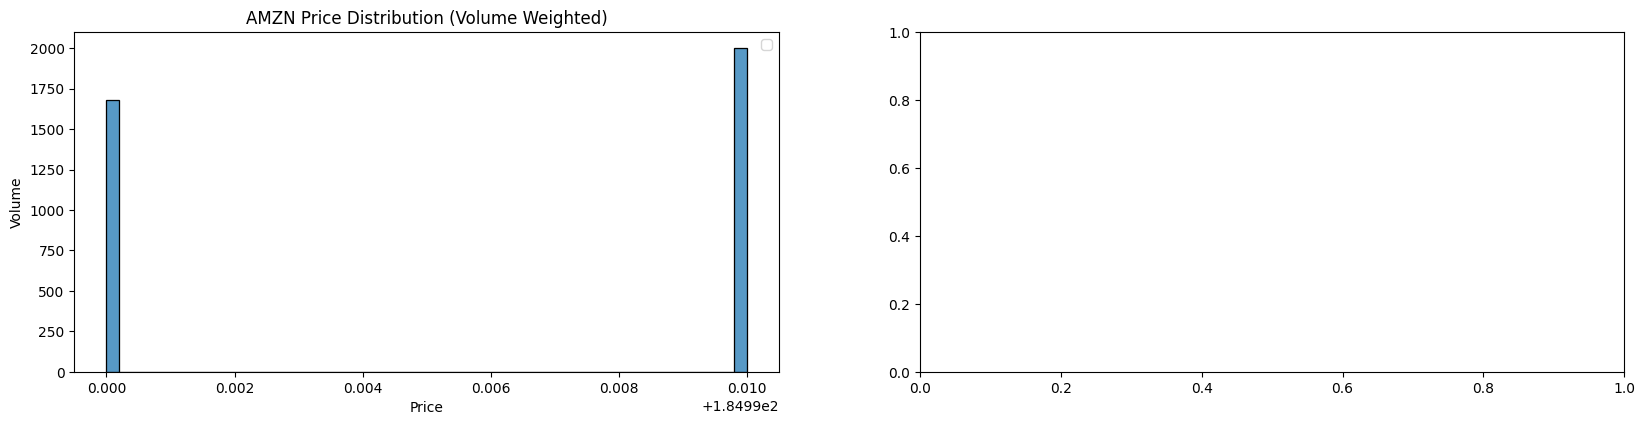

In [95]:
# Cell 5: Usage Example
# Fetch data (will use cache if available)
trades_df = fetch_all_trades(symbols=['SPY', 'QQQ'], force_refresh = True)

if not trades_df.empty:
    # Analyze each symbol
    for symbol in trades_df['ticker'].unique():
        symbol_trades = trades_df[trades_df['ticker'] == symbol]
        sentiment = analyze_sentiment(symbol_trades)
        
        print(f"\n=== {symbol} Analysis ===")
        print(f"Total Trades: {len(symbol_trades)}")
        print(f"Total Volume: {symbol_trades['size'].sum():,.0f}")
        print(f"VWAP: ${symbol_trades['price'].mean():.2f}")
        print(f"Average Premium: {sentiment['vwap_premium']:.2%}")
        print(f"Sentiment Score: {sentiment['sentiment_score']:.2f} (-1 bearish to 1 bullish)")
        print(f"Bullish Volume: {sentiment['bullish_volume']:,.0f}")
        print(f"Bearish Volume: {sentiment['bearish_volume']:,.0f}")
        
        # Create visualizations
        plot_dark_pool_analysis(trades_df, symbol, target_price=510 if symbol == 'SPY' else None)
        
        # Additional analysis for SPY position
        if symbol == 'SPY':
            print("\n=== SPY Position Analysis (510 Target) ===")
            below_510 = symbol_trades[symbol_trades['price'] < 510]
            above_510 = symbol_trades[symbol_trades['price'] >= 510]
            
            print(f"Volume below $510: {below_510['size'].sum():,.0f} ({below_510['size'].sum()/symbol_trades['size'].sum():.1%})")
            print(f"Volume above $510: {above_510['size'].sum():,.0f} ({above_510['size'].sum()/symbol_trades['size'].sum():.1%})")
            print(f"Average premium below $510: {below_510['premium'].mean():.2%}")
            print(f"Average premium above $510: {above_510['premium'].mean():.2%}")
else:
    print("No trades found for analysis")

In [96]:
def test_api_endpoints():
    """Test different API endpoints and parameters to understand the API better"""
    test_date = "2025-04-11"
    test_symbol = "SPY"
    
    # Test 1: Check different parameter combinations for /darkpool/{ticker}
    print("\nTest 1: /darkpool/{ticker} with different parameters")
    test_params = [
        {"date": test_date, "limit": 200},
        {"date": test_date, "limit": 200, "offset": 0},
        {"date": test_date, "limit": 200, "offset": 200},
        {"date": test_date, "limit": 200, "offset": 400},
        {"date": test_date, "limit": 200, "sort": "desc"},
        {"date": test_date, "limit": 200, "sort": "asc"},
    ]
    
    for params in test_params:
        try:
            print(f"\nTrying params: {params}")
            response = requests.get(
                f"{DARKPOOL_ENDPOINT}/{test_symbol}",
                headers=DEFAULT_HEADERS,
                params=params,
                timeout=REQUEST_TIMEOUT
            )
            data = response.json()
            print(f"Status: {response.status_code}")
            print(f"Number of trades: {len(data.get('data', []))}")
            if data.get('data'):
                print(f"First trade timestamp: {data['data'][0].get('executed_at')}")
                print(f"Last trade timestamp: {data['data'][-1].get('executed_at')}")
        except Exception as e:
            print(f"Error: {str(e)}")
    
    # Test 2: Check /darkpool/recent with different parameters
    print("\nTest 2: /darkpool/recent with different parameters")
    test_params = [
        {"symbol": test_symbol, "limit": 200},
        {"symbol": test_symbol, "limit": 200, "offset": 0},
        {"symbol": test_symbol, "limit": 200, "offset": 200},
        {"symbol": test_symbol, "limit": 200, "offset": 400},
        {"symbol": test_symbol, "limit": 200, "sort": "desc"},
        {"symbol": test_symbol, "limit": 200, "sort": "asc"},
    ]
    
    for params in test_params:
        try:
            print(f"\nTrying params: {params}")
            response = requests.get(
                f"{DARKPOOL_ENDPOINT}/recent",
                headers=DEFAULT_HEADERS,
                params=params,
                timeout=REQUEST_TIMEOUT
            )
            data = response.json()
            print(f"Status: {response.status_code}")
            print(f"Number of trades: {len(data.get('data', []))}")
            if data.get('data'):
                print(f"First trade timestamp: {data['data'][0].get('executed_at')}")
                print(f"Last trade timestamp: {data['data'][-1].get('executed_at')}")
        except Exception as e:
            print(f"Error: {str(e)}")
    
    # Test 3: Check if we can get trades for a specific time range
    print("\nTest 3: Time range parameters")
    try:
        response = requests.get(
            f"{DARKPOOL_ENDPOINT}/{test_symbol}",
            headers=DEFAULT_HEADERS,
            params={
                "date": test_date,
                "limit": 200,
                "start_time": "09:30:00",
                "end_time": "16:00:00"
            },
            timeout=REQUEST_TIMEOUT
        )
        print(f"Status: {response.status_code}")
        print(f"Response: {response.json()}")
    except Exception as e:
        print(f"Error: {str(e)}")

# Run the tests
test_api_endpoints()


Test 1: /darkpool/{ticker} with different parameters

Trying params: {'date': '2025-04-11', 'limit': 200}
Status: 200
Number of trades: 200
First trade timestamp: 2025-04-11T23:59:38Z
Last trade timestamp: 2025-04-11T20:05:00Z

Trying params: {'date': '2025-04-11', 'limit': 200, 'offset': 0}
Status: 200
Number of trades: 200
First trade timestamp: 2025-04-11T23:59:38Z
Last trade timestamp: 2025-04-11T20:05:00Z

Trying params: {'date': '2025-04-11', 'limit': 200, 'offset': 200}
Status: 200
Number of trades: 200
First trade timestamp: 2025-04-11T23:59:38Z
Last trade timestamp: 2025-04-11T20:05:00Z

Trying params: {'date': '2025-04-11', 'limit': 200, 'offset': 400}
Status: 200
Number of trades: 200
First trade timestamp: 2025-04-11T23:59:38Z
Last trade timestamp: 2025-04-11T20:05:00Z

Trying params: {'date': '2025-04-11', 'limit': 200, 'sort': 'desc'}
Status: 200
Number of trades: 200
First trade timestamp: 2025-04-11T23:59:38Z
Last trade timestamp: 2025-04-11T20:05:00Z

Trying params: {